<a href="https://colab.research.google.com/github/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation/blob/main/Detect_the_types_of_viruses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation.git

Cloning into 'Prediction-Recommedation-system-for-Potato-Cultivation'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 238 (delta 82), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (238/238), 67.44 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pickle

data_path = '/content/drive/MyDrive/Data/M_Data'
classes = {'PSTV foliar symptoms': 0, 'Rugose mosaic symptom': 1}

In [5]:
# Read the data file names and corresponding labels
data = []
labels = []
for class_name, label in classes.items():
    class_path = os.path.join(data_path, class_name)
    file_names = os.listdir(class_path)
    for file_name in file_names:
        file_path = os.path.join(class_path, file_name)
        data.append(file_path)
        labels.append(label)

In [6]:
 # Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)


In [7]:
# Load and preprocess the images
def preprocess_image(image_path):
    image = cv2.imread(image_path)

    # Background removal using thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    image[thresholded == 0] = [0, 0, 0]  # Set background pixels to black

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (128, 128))
    return image

train_images = [preprocess_image(image_path) for image_path in train_data]
val_images = [preprocess_image(image_path) for image_path in val_data]
test_images = [preprocess_image(image_path) for image_path in test_data]

In [8]:
# Print the size of each set
print('Training set size:', len(train_data))
print('Validation set size:', len(val_data))
print('Testing set size:', len(test_data))

Training set size: 448
Validation set size: 112
Testing set size: 140


In [9]:
# Convert the images and labels to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [10]:
# FEATURE EXTRACTOR function
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):
        df = pd.DataFrame()
        img = x_train[image]

        # FEATURE 1 - Pixel values
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values

        # FEATURE 2 - Gabor filter responses
        num = 1
        kernels = []
        for theta in range(2):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                lamda = np.pi / 4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)
                kernel = cv2.getGaborKernel((9, 9), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img
                num += 1

        # Append features from the current image to the dataset
        image_dataset = image_dataset.append(df)

    return image_dataset

# Extract features from training images
image_features = feature_extractor(train_images)

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [11]:
# Reshape for SVM training
n_samples = train_images.shape[0]
image_features = np.array(image_features)
image_features = np.reshape(image_features, (n_samples, -1))

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Reshape for SVM training
n_samples = train_images.shape[0]
image_features = np.array(image_features)
image_features = np.reshape(image_features, (n_samples, -1))

# Define the hyperparameters and their possible values
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}

# Create an SVM model
svm_model = SVC()

# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(image_features, train_labels)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)



Best Hyperparameters:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}


In [ ]:

# Retrain the model using the best hyperparameters
best_svm_model = SVC(**grid_search.best_params_)
best_svm_model.fit(image_features, train_labels)

# Reshape the test dataset
n_test_samples = test_images.shape[0]
test_features = np.array(test_images)
test_features = np.reshape(test_features, (n_test_samples, -1))

# Evaluate the final model on the test dataset
accuracy = best_svm_model.score(test_features, test_labels)
print("Accuracy on test set: ", accuracy)

## SVM classification


In [53]:
# Define the classifier
SVM_model = SVC(kernel='rbf', random_state=42)

In [54]:
# Fit the model on training data
SVM_model.fit(image_features, train_labels)

# Save the trained model
with open('/content/drive/MyDrive/Data/SVM_model.pkl', 'wb') as file:
    pickle.dump(SVM_model, file)

# Extract features from test data and reshape
test_features = feature_extractor(test_images)
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_images.shape[0], -1))

# Predict on test data
test_predictions = SVM_model.predict(test_features)

# Convert labels back to original class names
le = LabelEncoder()
le.fit(labels)
test_predictions = le.inverse_transform(test_predictions)



<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [55]:
# Print overall accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9357142857142857


In [18]:
# Print precision, recall, and F1 score
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Svm Precision:", precision)
print("svm Recall:", recall)
print("svm F1 Score:", f1)

Svm Precision: 0.9418766627806174
svm Recall: 0.9357142857142857
svm F1 Score: 0.9364099517945671


KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
# Train KNN classifier
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(image_features, train_labels)

# Predict on test data using KNN
test_predictions_knn = KNN_model.predict(test_features)

# Convert labels back to original class names
test_predictions_knn = le.inverse_transform(test_predictions_knn)

In [17]:
# Print overall accuracy for KNN
test_accuracy_knn = accuracy_score(test_labels, test_predictions_knn)
print("KNN Test Accuracy:", test_accuracy_knn)

# Print precision, recall, and F1 score for KNN
precision_knn = precision_score(test_labels, test_predictions_knn, average='weighted')
recall_knn = recall_score(test_labels, test_predictions_knn, average='weighted')
f1_knn = f1_score(test_labels, test_predictions_knn, average='weighted')
print("KNN Precision:", precision_knn)
print("KNN Recall:", recall_knn)
print("KNN F1 Score:", f1_knn)

KNN Test Accuracy: 0.6857142857142857
KNN Precision: 0.8297619047619047
KNN Recall: 0.6857142857142857
KNN F1 Score: 0.6800514800514801


random forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest classifier
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(image_features, train_labels)

# Predict on test data using Random Forest
test_predictions_rf = RF_model.predict(test_features)

# Convert labels back to original class names
test_predictions_rf = le.inverse_transform(test_predictions_rf)


In [20]:
# Print overall accuracy for Random Forest
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print("Random Forest Test Accuracy:", test_accuracy_rf)

# Print precision, recall, and F1 score for Random Forest
precision_rf = precision_score(test_labels, test_predictions_rf, average='weighted')
recall_rf = recall_score(test_labels, test_predictions_rf, average='weighted')
f1_rf = f1_score(test_labels, test_predictions_rf, average='weighted')
print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)
print("Random Forest F1 Score:", f1_rf)


Random Forest Test Accuracy: 0.9071428571428571
Random Forest Precision: 0.9068643187612123
Random Forest Recall: 0.9071428571428571
Random Forest F1 Score: 0.9069544026266094


Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree classifier
DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(image_features, train_labels)

# Predict on test data using Decision Tree
test_predictions_dt = DT_model.predict(test_features)

# Convert labels back to original class names
test_predictions_dt = le.inverse_transform(test_predictions_dt)

# Print overall accuracy for Decision Tree
test_accuracy_dt = accuracy_score(test_labels, test_predictions_dt)
print("Decision Tree Test Accuracy:", test_accuracy_dt)

# Print precision, recall, and F1 score for Decision Tree
precision_dt = precision_score(test_labels, test_predictions_dt, average='weighted')
recall_dt = recall_score(test_labels, test_predictions_dt, average='weighted')
f1_dt = f1_score(test_labels, test_predictions_dt, average='weighted')
print("Decision Tree Precision:", precision_dt)
print("Decision Tree Recall:", recall_dt)
print("Decision Tree F1 Score:", f1_dt)


Decision Tree Test Accuracy: 0.7785714285714286
Decision Tree Precision: 0.8276043956043957
Decision Tree Recall: 0.7785714285714286
Decision Tree F1 Score: 0.7819787232478295


In [22]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes classifier
NB_model = GaussianNB()
NB_model.fit(image_features, train_labels)

# Predict on test data using Naive Bayes
test_predictions_nb = NB_model.predict(test_features)

# Convert labels back to original class names
test_predictions_nb = le.inverse_transform(test_predictions_nb)

# Print overall accuracy for Naive Bayes
test_accuracy_nb = accuracy_score(test_labels, test_predictions_nb)
print("Naive Bayes Test Accuracy:", test_accuracy_nb)

# Print precision, recall, and F1 score for Naive Bayes
precision_nb = precision_score(test_labels, test_predictions_nb, average='weighted')
recall_nb = recall_score(test_labels, test_predictions_nb, average='weighted')
f1_nb = f1_score(test_labels, test_predictions_nb, average='weighted')
print("Naive Bayes Precision:", precision_nb)
print("Naive Bayes Recall:", recall_nb)
print("Naive Bayes F1 Score:", f1_nb)


Naive Bayes Test Accuracy: 0.6642857142857143
Naive Bayes Precision: 0.7050442503724041
Naive Bayes Recall: 0.6642857142857143
Naive Bayes F1 Score: 0.6697437788018433


In [23]:
import xgboost as xgb

# Train XGBoost classifier
XGB_model = xgb.XGBClassifier(random_state=42)
XGB_model.fit(image_features, train_labels)

# Predict on test data using XGBoost
test_predictions_xgb = XGB_model.predict(test_features)

# Convert labels back to original class names
test_predictions_xgb = le.inverse_transform(test_predictions_xgb)

# Print overall accuracy for XGBoost
test_accuracy_xgb = accuracy_score(test_labels, test_predictions_xgb)
print("XGBoost Test Accuracy:", test_accuracy_xgb)

# Print precision, recall, and F1 score for XGBoost
precision_xgb = precision_score(test_labels, test_predictions_xgb, average='weighted')
recall_xgb = recall_score(test_labels, test_predictions_xgb, average='weighted')
f1_xgb = f1_score(test_labels, test_predictions_xgb, average='weighted')
print("XGBoost Precision:", precision_xgb)
print("XGBoost Recall:", recall_xgb)
print("XGBoost F1 Score:", f1_xgb)


XGBoost Test Accuracy: 0.9
XGBoost Precision: 0.902891156462585
XGBoost Recall: 0.9
XGBoost F1 Score: 0.9006890611541774


In [63]:
from sklearn.metrics import classification_report

# Generate classification report for SVM
svm_report = classification_report(test_labels, test_predictions)
print("SVM Classification Report:")
print(svm_report)

# Generate classification report for KNN
knn_report = classification_report(test_labels, test_predictions_knn)
print("KNN Classification Report:")
print(knn_report)

# Generate classification report for Random Forest
rf_report = classification_report(test_labels, test_predictions_rf)
print("Random Forest Classification Report:")
print(rf_report)

# Generate classification report for Decision Tree
dt_report = classification_report(test_labels, test_predictions_dt)
print("Decision Tree Classification Report:")
print(dt_report)

# Generate classification report for Naive Bayes
nb_report = classification_report(test_labels, test_predictions_nb)
print("Naive Bayes Classification Report:")
print(nb_report)

# Generate classification report for Gradient Boosting
xgb_report = classification_report(test_labels, test_predictions_xgb)
print("Gradient Boosting Classification Report:")
print(xgb_report)


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        88
           1       0.86      0.98      0.92        52

    accuracy                           0.94       140
   macro avg       0.93      0.94      0.93       140
weighted avg       0.94      0.94      0.94       140

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        88
           1       0.54      1.00      0.70        52

    accuracy                           0.69       140
   macro avg       0.77      0.75      0.68       140
weighted avg       0.83      0.69      0.68       140

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        88
           1       0.88      0.87      0.87        52

    accuracy                           0.91       140
   macro avg       0.90      0.90    

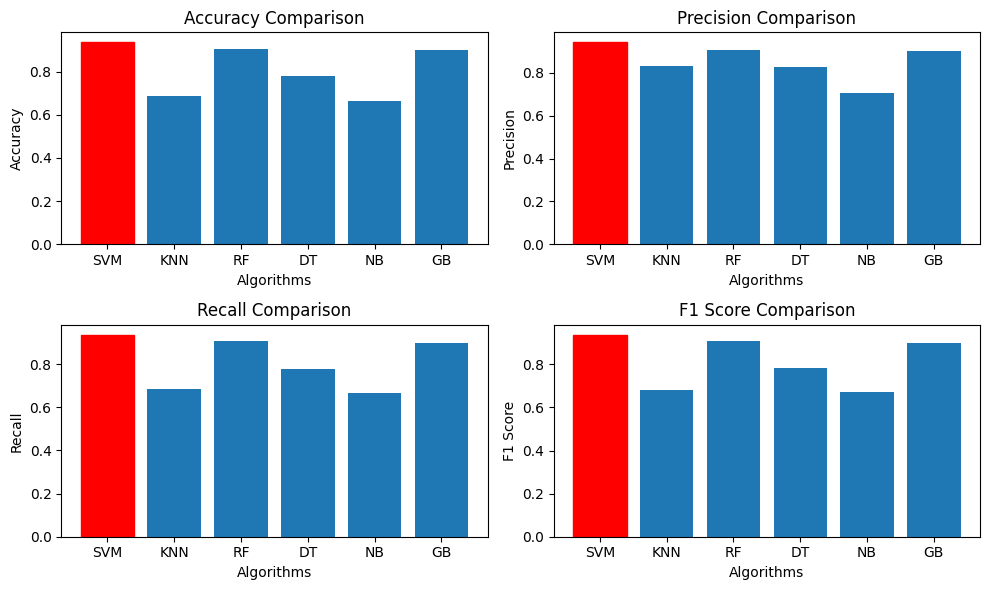

In [36]:
import matplotlib.pyplot as plt

# List of algorithm names
algorithms = ['SVM', 'KNN', 'RF', 'DT', 'NB', 'GB']

# List of accuracy scores
accuracy_scores = [test_accuracy, test_accuracy_knn, test_accuracy_rf, test_accuracy_dt, test_accuracy_nb, test_accuracy_xgb]

# List of precision scores
precision_scores = [precision, precision_knn, precision_rf, precision_dt, precision_nb, precision_xgb]

# List of recall scores
recall_scores = [recall, recall_knn, recall_rf, recall_dt, recall_nb, recall_xgb]

# List of F1 scores
f1_scores = [f1, f1_knn, f1_rf, f1_dt, f1_nb, f1_xgb]

# Find the index of the algorithm with the highest score in each metric
highest_accuracy_index = accuracy_scores.index(max(accuracy_scores))
highest_precision_index = precision_scores.index(max(precision_scores))
highest_recall_index = recall_scores.index(max(recall_scores))
highest_f1_index = f1_scores.index(max(f1_scores))

# Plotting the scores with highlighting the highest ones
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 2, 1)
bars = plt.bar(algorithms, accuracy_scores)
bars[highest_accuracy_index].set_color('red')
plt.title('Accuracy Comparison')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')

# Precision plot
plt.subplot(2, 2, 2)
bars = plt.bar(algorithms, precision_scores)
bars[highest_precision_index].set_color('red')
plt.title('Precision Comparison')
plt.xlabel('Algorithms')
plt.ylabel('Precision')

# Recall plot
plt.subplot(2, 2, 3)
bars = plt.bar(algorithms, recall_scores)
bars[highest_recall_index].set_color('red')
plt.title('Recall Comparison')
plt.xlabel('Algorithms')
plt.ylabel('Recall')

# F1 Score plot
plt.subplot(2, 2, 4)
bars = plt.bar(algorithms, f1_scores)
bars[highest_f1_index].set_color('red')
plt.title('F1 Score Comparison')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()



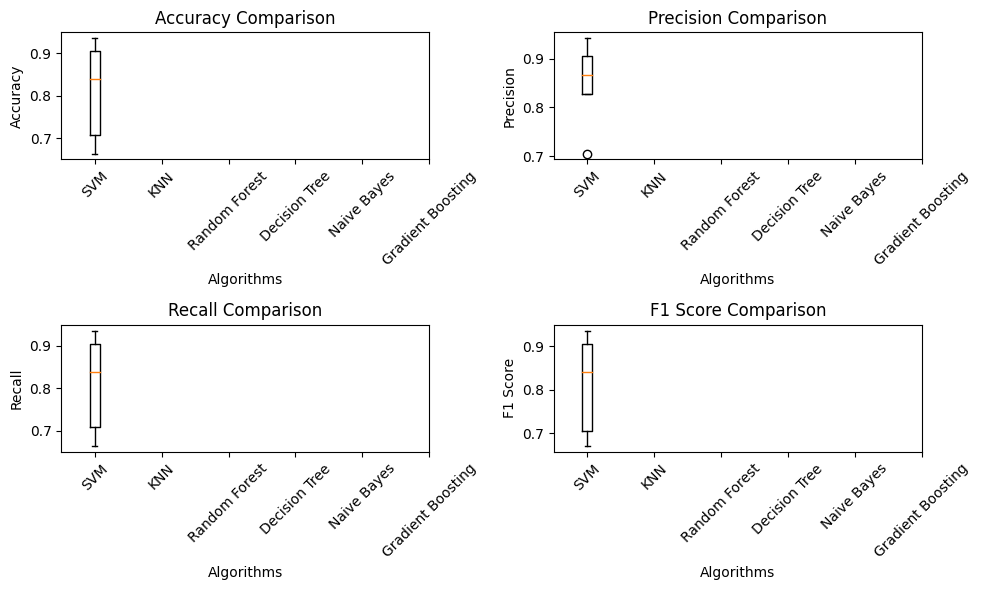

In [27]:
# Create a list of evaluation metric scores for each algorithm
accuracy_scores = [test_accuracy, test_accuracy_knn, test_accuracy_rf, test_accuracy_dt, test_accuracy_nb, test_accuracy_xgb]
precision_scores = [precision, precision_knn, precision_rf, precision_dt, precision_nb, precision_xgb]
recall_scores = [recall, recall_knn, recall_rf, recall_dt, recall_nb, recall_xgb]
f1_scores = [f1, f1_knn, f1_rf, f1_dt, f1_nb, f1_xgb]

# Create a dictionary to store the scores for each algorithm
algorithm_scores = {
    'SVM': accuracy_scores[0],
    'KNN': accuracy_scores[1],
    'Random Forest': accuracy_scores[2],
    'Decision Tree': accuracy_scores[3],
    'Naive Bayes': accuracy_scores[4],
    'Gradient Boosting': accuracy_scores[5]
}

# Create a list of algorithm names
algorithm_names = list(algorithm_scores.keys())

# Create a list of score lists for box plot
score_lists = [accuracy_scores, precision_scores, recall_scores, f1_scores]

# Create a list of metric names
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the box plots
plt.figure(figsize=(10, 6))

for i in range(len(score_lists)):
    plt.subplot(2, 2, i+1)
    plt.boxplot(score_lists[i])
    plt.title(metric_names[i] + ' Comparison')
    plt.xlabel('Algorithms')
    plt.ylabel(metric_names[i])
    plt.xticks(range(1, len(algorithm_names) + 1), algorithm_names, rotation=45)

plt.tight_layout()
plt.show()


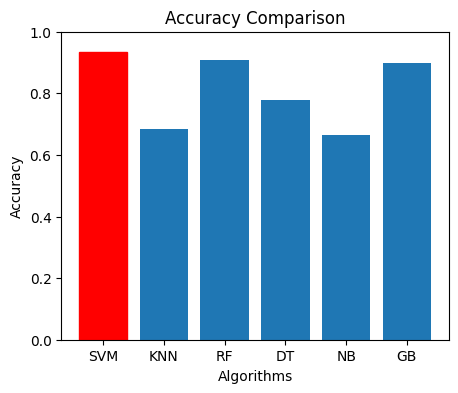

In [61]:
# Create a list of accuracy scores for each algorithm
accuracy_scores = [test_accuracy, test_accuracy_knn, test_accuracy_rf, test_accuracy_dt, test_accuracy_nb, test_accuracy_xgb]

# Create a list of algorithm names
algorithm_names = ['SVM', 'KNN', 'RF', 'DT', 'NB', 'GB']

# Find the index of the algorithm with the highest accuracy score
highest_accuracy_index = accuracy_scores.index(max(accuracy_scores))

# Plotting the accuracy scores with highlighting the highest one
plt.figure(figsize=(5, 4))
bars = plt.bar(algorithm_names, accuracy_scores)
bars[highest_accuracy_index].set_color('red')  # Highlight the highest accuracy bar
plt.title('Accuracy Comparison')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Reshape for SVM training
n_samples = train_images.shape[0]
image_features = np.array(image_features)
image_features = np.reshape(image_features, (n_samples, -1))

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear']}

# Create an instance of the SVM classifier
svm_model = SVC()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVM_model, param_grid=param_grid, scoring='accuracy')

# Fit the model on training data with grid search
grid_search.fit(image_features, train_labels)

# Retrieve the best hyperparameters and test accuracy
best_params = grid_search.best_params_
test_accuracy = grid_search.best_score_

# Print the best hyperparameters and test accuracy
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)


Best Hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Test Accuracy: 0.8503620474406992


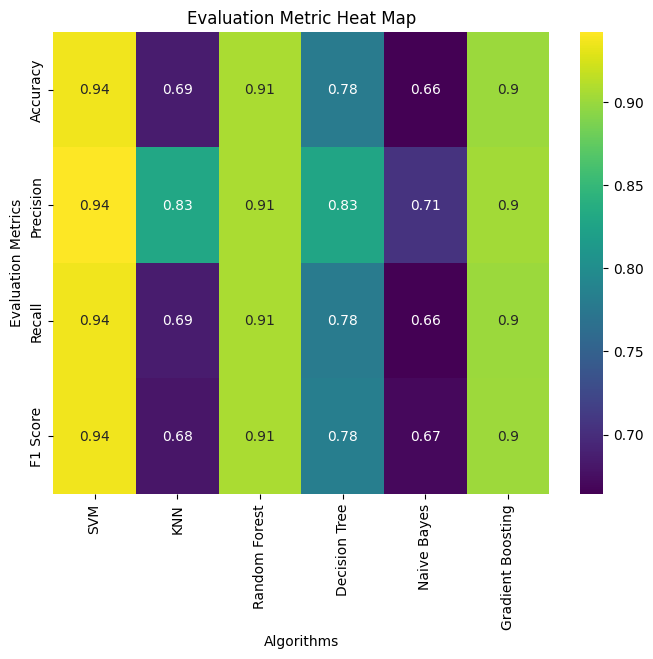

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D array of metric scores
metric_scores = np.array([accuracy_scores, precision_scores, recall_scores, f1_scores])

# Define the algorithm names
algorithm_names = ['SVM', 'KNN', 'Random Forest', 'Decision Tree', 'Naive Bayes', 'Gradient Boosting']

# Create a heat map using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(metric_scores, annot=True, cmap='viridis', xticklabels=algorithm_names, yticklabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add labels and title
plt.xlabel('Algorithms')
plt.ylabel('Evaluation Metrics')
plt.title('Evaluation Metric Heat Map')

# Show the plot
plt.show()


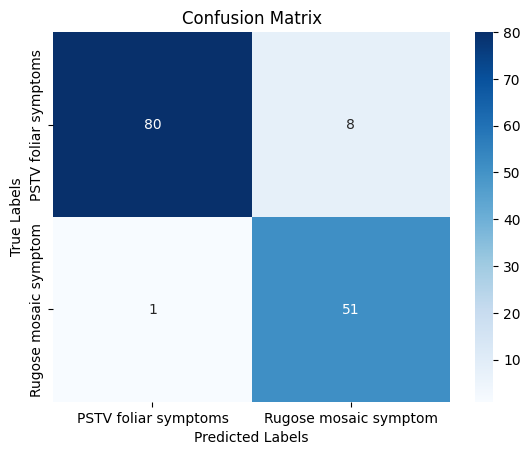

In [71]:
# Print confusion matrix
confusion = confusion_matrix(test_labels, test_predictions)
class_names = list(classes.keys())
fig, ax = plt.subplots()
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


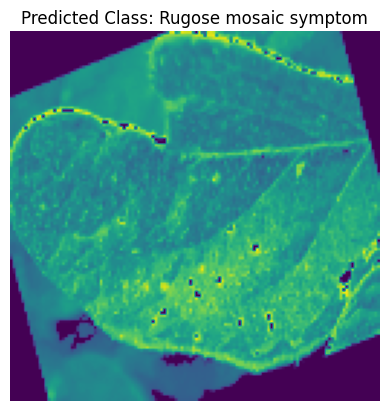

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


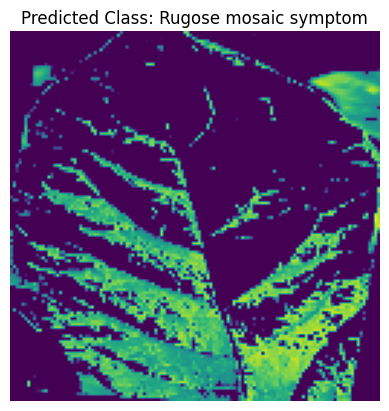

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


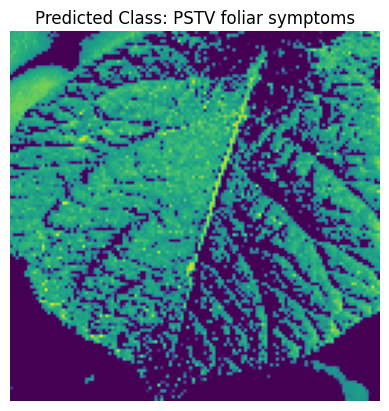

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


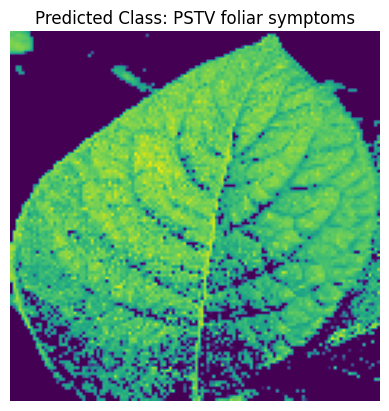

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


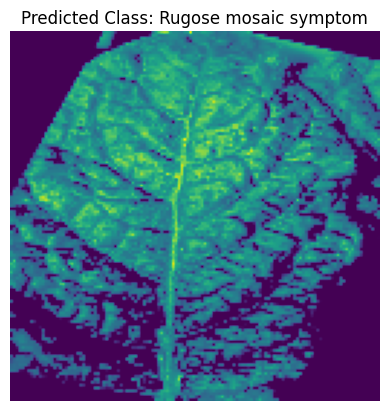

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


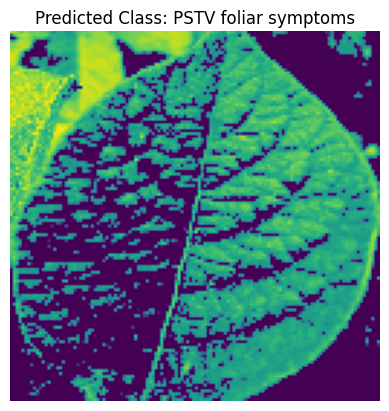

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


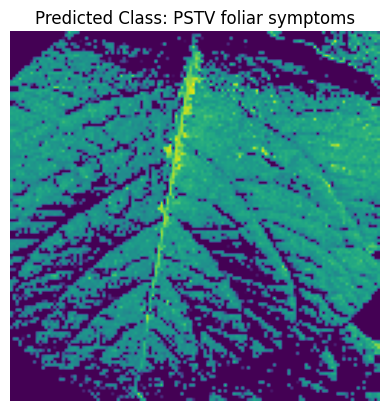

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


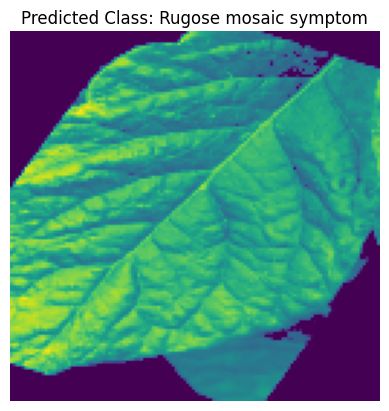

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


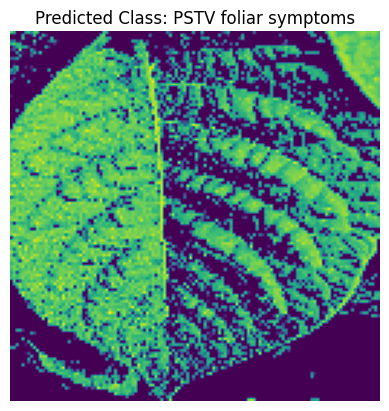

<ipython-input-10-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


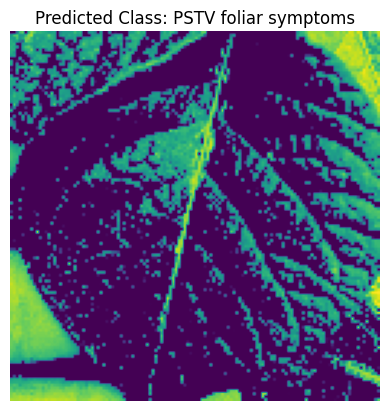

In [76]:
# Import the necessary libraries
import random

# Select 10 random indices from the test dataset
random_indices = random.sample(range(len(test_data)), 10)

# Iterate over the random indices and make predictions
for index in random_indices:
    # Get the image path and preprocess the image
    image_path = test_data[index]
    preprocessed_image = preprocess_image(image_path)

    # Extract features and reshape for prediction
    input_img = np.expand_dims(preprocessed_image, axis=0)
    input_img_features = feature_extractor(input_img)
    input_img_features = np.expand_dims(input_img_features, axis=0)
    input_img_for_SVM = np.reshape(input_img_features, (input_img.shape[0], -1))

    # Make the prediction
    img_prediction = SVM_model.predict(input_img_for_SVM)
    img_prediction = le.inverse_transform(img_prediction)

    # Convert the class label to class name
    prediction_class_name = class_names[img_prediction[0]]

    # Display the image and predicted class
    plt.imshow(preprocessed_image, cmap='viridis')
    plt.axis('off')
    plt.title("Predicted Class: " + prediction_class_name)
    plt.show()